In [1]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

model = HuggingFaceEmbedding(
    model_name="llamaindex/vdr-2b-multi-v1",
    device="cpu",  # "mps" for mac, "cuda" for nvidia GPUs
    trust_remote_code=True,
)

documents = [
    {"caption": "An image about plane emergency safety.", "image": "../images/image-1.png"},
    {"caption": "An image about airplane components.", "image": "../images/image-2.png"},
    {"caption": "An image about COVID safety restrictions.", "image": "../images/image-3.png"},
    {"caption": "An confidential image about UFO sightings.", "image": "../images/image-4.png"},
    {"caption": "An image about unusual footprints on Aralar 2011.", "image":"../images/image-5.png"},
]

text_embeddings = model.get_text_embedding_batch([doc["caption"] for doc in documents])
image_embeddings = model.get_image_embedding_batch([doc["image"] for doc in documents])

c:\Ambarish\qdrant_examples\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [2]:
image_embeddings[0][:5]  # first 5 dimensions of the first image embedding

[-0.0002356307377340272,
 -0.04563727229833603,
 0.06666415929794312,
 0.03008490428328514,
 0.03971279785037041]

In [3]:
import os

In [4]:
url = os.getenv("QDRANT_URL")
api_key = os.getenv("QDRANT_KEY")

In [5]:
print("QDRANT_URL:", url)

QDRANT_URL: https://ced14d39-06fd-4db8-b81b-86adb4f34001.eu-west-1-0.aws.cloud.qdrant.io


In [6]:
from qdrant_client import QdrantClient, models

# docker run -p 6333:6333 qdrant/qdrant
client = QdrantClient(url=url, api_key=api_key)

In [7]:
COLLECTION_NAME = "llama-multi"

if not client.collection_exists(COLLECTION_NAME):
    client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config={
            "image": models.VectorParams(size=len(image_embeddings[0]), distance=models.Distance.COSINE),
            "text": models.VectorParams(size=len(text_embeddings[0]), distance=models.Distance.COSINE),
        }
    )

In [8]:
client.upload_points(
    collection_name=COLLECTION_NAME,
    points=[
        models.PointStruct(
            id=idx,
            vector={
                "text": text_embeddings[idx],
                "image": image_embeddings[idx],
            },
            payload=doc
        )
        for idx, doc in enumerate(documents)
    ]
)

In [9]:
from PIL import Image

In [10]:
model

HuggingFaceEmbedding(model_name='llamaindex/vdr-2b-multi-v1', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x000001FE43E7AC60>, num_workers=None, embeddings_cache=None, max_length=32768, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None, show_progress_bar=False)

In [11]:
model.get_text_embedding("An image about plane emergency safety.")[:5]  # first 5 dimensions of the first text embedding

[-0.0408567450940609,
 0.004730848129838705,
 0.008273120038211346,
 -0.008035300299525261,
 0.05679834634065628]

In [12]:
find_image = model.get_text_embedding("Adventures on snow hills")

In [13]:
image_name = client.query_points(
    collection_name=COLLECTION_NAME,
    query=find_image,
    using="image",
    with_payload=["image"],
    limit=1
).points[0].payload['image']

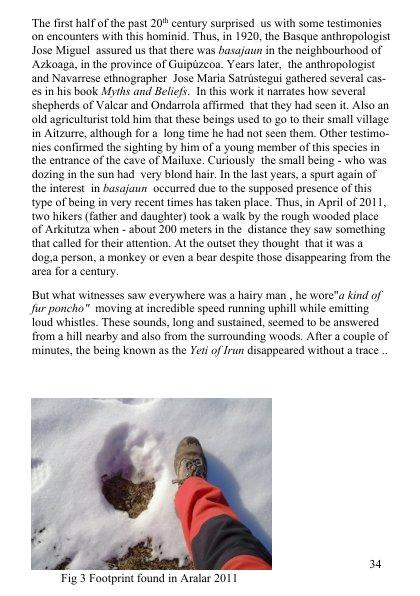

In [14]:
Image.open(image_name)

In [15]:
client.query_points(
    collection_name=COLLECTION_NAME,
    query=model.get_image_embedding("images/image-2.png"),  
    # Now we are searching only among text vectors with our image query
    using="text",
    with_payload=["caption"],
    limit=1
).points[0].payload['caption']

'An image about airplane components.'